In [2]:
%pip install gdown
%pip install tqdm
import gdown

url = "https://drive.google.com/drive/folders/1iYO-Kwh4RFq6mm5UNPTRO7te8T6jOA6f?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/Dataset/AlexNet.py',
 '/content/Dataset/custom_cnn.py',
 '/content/Dataset/Dataset_resized.zip']

In [3]:
import os
import zipfile
import shutil
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from Dataset.custom_cnn import CNN
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import seaborn as sns
import matplotlib.pyplot as plt
import math


# path of the dataset
dataset_path = "Dataset"

# extract zip files and remove them
def extract_and_remove_zip(zip_path, extract_to):
    """
    Estrae il contenuto di un file zip e poi elimina il file zip.
    Args:
        zip_path (str): percorso del file zip da estrarre.
        extract_to (str): cartella di destinazione in cui estrarre i file.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)
    print(f"File zip {zip_path} estratto e rimosso.")

zip_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]
for zip_file in zip_files:
    zip_path = os.path.join(dataset_path, zip_file)
    extract_and_remove_zip(zip_path, dataset_path)


print("Process completed!")




File zip Dataset/Dataset_resized.zip estratto e rimosso.
Process completed!


**Conteggio numero immagini per ogni set**

In [3]:
dataset_path = "Dataset"
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    if os.path.isdir(folder_path):
        train_folder = os.path.join(folder_path, "train")
        test_folder = os.path.join(folder_path, "test")

        train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
        test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

        print(f"Cartella '{folder}':")
        print(f"  Train set: {train_count} file")
        print(f"  Test set: {test_count} file")

Cartella 'nose':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'mouth':
  Train set: 18255 file
  Test set: 4776 file
Cartella '__pycache__':
  Train set: 0 file
  Test set: 0 file
Cartella 'eyes':
  Train set: 18255 file
  Test set: 4776 file


In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
# Transform eyes (266 x 44)
transform_eyes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.56551169, 0.4201522,  0.35519068], std = [0.22746577, 0.20109357, 0.19388984])
])

# Transform nose (108x170)
transform_nose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.70585869, 0.5230923,  0.44163547], std = [0.19556989, 0.19164655, 0.19488743])
])

# Transform mouth (193x89)
transform_mouth = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.64867712, 0.4592991,  0.39606173], std = [0.2005014,  0.18597975, 0.18335514])
])

class EthnicityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                self.images.append(filename)

                # extract labels
                # example: eyes_100_1_0_20170112213001988
                parts = filename.split('_')
                if len(parts) >= 4:
                    label = parts[3]  # fourth element (index 3)
                    label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Map ethnicities
                    self.labels.append(label_map.get(label, -1))  # no ethnicity found

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error: loading of the image {image_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        # Check if label is correct
        if label == -1:
            print(f"Error: no label found {image_name}")

        return image, label

In [6]:
e_x = 16
e_y = 2
n_x = 6
n_y = 10
m_x = 12
m_y = 5

hid_1 = 64
hid_2 = 64
hid_3 = 128
hid_4 = 128
hid_5 = 128
hid_6 = 128
drop_1 = 0.2
drop_2 = 0.5


class_names = ["White", "Black", "Asian", "Indian", "Others"]

**EYES TRAINING VALIDATION AND TEST**

In [7]:
# Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/eyes/train", transform=transform_eyes)
test_dataset = EthnicityDataset(root_dir="Dataset/eyes/test", transform=transform_eyes)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-fold Cross-Validation
k = 5  # Choose K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array to store results for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

num_epochs = 12
batch_size = 64

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model and optimizer for each fold
    eyes_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, e_x, e_y, drop_1, drop_2)
    eyes_net = eyes_net.to(device)  # Ensure the model is on the correct GPU/CPU
    eyes_optimizer = torch.optim.Adam(eyes_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Metrics for each fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training for each fold
    for epoch in range(num_epochs):
        # Training Phase
        eyes_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            eyes_optimizer.zero_grad()

            # Forward pass
            outputs = eyes_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            eyes_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        eyes_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = eyes_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = eyes_net.state_dict()
            print(f"New best model saved with Val Accuracy: {best_val_accuracy:.4f}")
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save results for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

torch.save(best_model_state, "best_eyes_net.pth")

# Calculate the average metrics across all folds
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 229/229 [00:33<00:00,  6.88batch/s]


Fold 1, Epoch 1, Train Loss: 1.1299, Train Accuracy: 0.5772


Validating Fold 1, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 16.32batch/s]


New best model saved with Val Accuracy: 0.6275
Fold 1, Epoch 1, Val Loss: 1.0055, Val Accuracy: 0.6275


Training Fold 1, Epoch 2: 100%|██████████| 229/229 [00:22<00:00,  9.97batch/s]


Fold 1, Epoch 2, Train Loss: 0.9375, Train Accuracy: 0.6559


Validating Fold 1, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 16.42batch/s]


New best model saved with Val Accuracy: 0.6472
Fold 1, Epoch 2, Val Loss: 0.9100, Val Accuracy: 0.6472


Training Fold 1, Epoch 3: 100%|██████████| 229/229 [00:22<00:00,  9.98batch/s]


Fold 1, Epoch 3, Train Loss: 0.8733, Train Accuracy: 0.6795


Validating Fold 1, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 16.60batch/s]


New best model saved with Val Accuracy: 0.6664
Fold 1, Epoch 3, Val Loss: 0.9054, Val Accuracy: 0.6664


Training Fold 1, Epoch 4: 100%|██████████| 229/229 [00:23<00:00,  9.88batch/s]


Fold 1, Epoch 4, Train Loss: 0.8220, Train Accuracy: 0.7043


Validating Fold 1, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.32batch/s]


New best model saved with Val Accuracy: 0.6998
Fold 1, Epoch 4, Val Loss: 0.8075, Val Accuracy: 0.6998


Training Fold 1, Epoch 5: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 1, Epoch 5, Train Loss: 0.7749, Train Accuracy: 0.7195


Validating Fold 1, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 16.46batch/s]


Fold 1, Epoch 5, Val Loss: 0.8480, Val Accuracy: 0.6826


Training Fold 1, Epoch 6: 100%|██████████| 229/229 [00:23<00:00,  9.61batch/s]


Fold 1, Epoch 6, Train Loss: 0.7288, Train Accuracy: 0.7351


Validating Fold 1, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 16.84batch/s]


New best model saved with Val Accuracy: 0.7228
Fold 1, Epoch 6, Val Loss: 0.7695, Val Accuracy: 0.7228


Training Fold 1, Epoch 7: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 1, Epoch 7, Train Loss: 0.6950, Train Accuracy: 0.7492


Validating Fold 1, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 16.38batch/s]


New best model saved with Val Accuracy: 0.7269
Fold 1, Epoch 7, Val Loss: 0.7546, Val Accuracy: 0.7269


Training Fold 1, Epoch 8: 100%|██████████| 229/229 [00:23<00:00,  9.92batch/s]


Fold 1, Epoch 8, Train Loss: 0.6496, Train Accuracy: 0.7661


Validating Fold 1, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 15.11batch/s]


Fold 1, Epoch 8, Val Loss: 0.7738, Val Accuracy: 0.7212


Training Fold 1, Epoch 9: 100%|██████████| 229/229 [00:23<00:00,  9.90batch/s]


Fold 1, Epoch 9, Train Loss: 0.6134, Train Accuracy: 0.7790


Validating Fold 1, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.90batch/s]


New best model saved with Val Accuracy: 0.7343
Fold 1, Epoch 9, Val Loss: 0.7487, Val Accuracy: 0.7343


Training Fold 1, Epoch 10: 100%|██████████| 229/229 [00:23<00:00,  9.91batch/s]


Fold 1, Epoch 10, Train Loss: 0.5797, Train Accuracy: 0.7916


Validating Fold 1, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 13.37batch/s]


Fold 1, Epoch 10, Val Loss: 0.7753, Val Accuracy: 0.7299


Training Fold 1, Epoch 11: 100%|██████████| 229/229 [00:23<00:00,  9.90batch/s]


Fold 1, Epoch 11, Train Loss: 0.5371, Train Accuracy: 0.8022


Validating Fold 1, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 14.13batch/s]


Fold 1, Epoch 11, Val Loss: 0.8022, Val Accuracy: 0.7217


Training Fold 1, Epoch 12: 100%|██████████| 229/229 [00:23<00:00,  9.87batch/s]


Fold 1, Epoch 12, Train Loss: 0.4976, Train Accuracy: 0.8185


Validating Fold 1, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.81batch/s]


Fold 1, Epoch 12, Val Loss: 0.8007, Val Accuracy: 0.7253
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 229/229 [00:23<00:00,  9.84batch/s]


Fold 2, Epoch 1, Train Loss: 1.1477, Train Accuracy: 0.5643


Validating Fold 2, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 16.15batch/s]


Fold 2, Epoch 1, Val Loss: 0.9274, Val Accuracy: 0.6464


Training Fold 2, Epoch 2: 100%|██████████| 229/229 [00:23<00:00,  9.81batch/s]


Fold 2, Epoch 2, Train Loss: 0.9521, Train Accuracy: 0.6476


Validating Fold 2, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 16.14batch/s]


Fold 2, Epoch 2, Val Loss: 0.8921, Val Accuracy: 0.6730


Training Fold 2, Epoch 3: 100%|██████████| 229/229 [00:23<00:00,  9.80batch/s]


Fold 2, Epoch 3, Train Loss: 0.8827, Train Accuracy: 0.6796


Validating Fold 2, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 16.45batch/s]


Fold 2, Epoch 3, Val Loss: 0.8649, Val Accuracy: 0.6856


Training Fold 2, Epoch 4: 100%|██████████| 229/229 [00:23<00:00,  9.95batch/s]


Fold 2, Epoch 4, Train Loss: 0.8292, Train Accuracy: 0.6989


Validating Fold 2, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.68batch/s]


Fold 2, Epoch 4, Val Loss: 0.8505, Val Accuracy: 0.6908


Training Fold 2, Epoch 5: 100%|██████████| 229/229 [00:22<00:00,  9.97batch/s]


Fold 2, Epoch 5, Train Loss: 0.7846, Train Accuracy: 0.7190


Validating Fold 2, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 16.83batch/s]


Fold 2, Epoch 5, Val Loss: 0.7585, Val Accuracy: 0.7201


Training Fold 2, Epoch 6: 100%|██████████| 229/229 [00:22<00:00, 10.03batch/s]


Fold 2, Epoch 6, Train Loss: 0.7311, Train Accuracy: 0.7354


Validating Fold 2, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 16.81batch/s]


Fold 2, Epoch 6, Val Loss: 0.7938, Val Accuracy: 0.7130


Training Fold 2, Epoch 7: 100%|██████████| 229/229 [00:22<00:00, 10.06batch/s]


Fold 2, Epoch 7, Train Loss: 0.7028, Train Accuracy: 0.7442


Validating Fold 2, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 16.83batch/s]


Fold 2, Epoch 7, Val Loss: 0.7555, Val Accuracy: 0.7253


Training Fold 2, Epoch 8: 100%|██████████| 229/229 [00:22<00:00,  9.97batch/s]


Fold 2, Epoch 8, Train Loss: 0.6717, Train Accuracy: 0.7562


Validating Fold 2, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 16.64batch/s]


Fold 2, Epoch 8, Val Loss: 0.7384, Val Accuracy: 0.7335


Training Fold 2, Epoch 9: 100%|██████████| 229/229 [00:22<00:00, 10.00batch/s]


Fold 2, Epoch 9, Train Loss: 0.6261, Train Accuracy: 0.7773


Validating Fold 2, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 16.64batch/s]


Fold 2, Epoch 9, Val Loss: 0.7581, Val Accuracy: 0.7343


Training Fold 2, Epoch 10: 100%|██████████| 229/229 [00:22<00:00, 10.02batch/s]


Fold 2, Epoch 10, Train Loss: 0.5843, Train Accuracy: 0.7896


Validating Fold 2, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 16.88batch/s]


Fold 2, Epoch 10, Val Loss: 0.7709, Val Accuracy: 0.7272


Training Fold 2, Epoch 11: 100%|██████████| 229/229 [00:22<00:00, 10.01batch/s]


Fold 2, Epoch 11, Train Loss: 0.5488, Train Accuracy: 0.8031


Validating Fold 2, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 16.63batch/s]


New best model saved with Val Accuracy: 0.7409
Fold 2, Epoch 11, Val Loss: 0.7471, Val Accuracy: 0.7409


Training Fold 2, Epoch 12: 100%|██████████| 229/229 [00:22<00:00, 10.03batch/s]


Fold 2, Epoch 12, Train Loss: 0.5042, Train Accuracy: 0.8204


Validating Fold 2, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.43batch/s]


Fold 2, Epoch 12, Val Loss: 0.8106, Val Accuracy: 0.7245
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 229/229 [00:22<00:00,  9.97batch/s]


Fold 3, Epoch 1, Train Loss: 1.1453, Train Accuracy: 0.5691


Validating Fold 3, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 14.98batch/s]


Fold 3, Epoch 1, Val Loss: 1.0858, Val Accuracy: 0.5960


Training Fold 3, Epoch 2: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 3, Epoch 2, Train Loss: 0.9613, Train Accuracy: 0.6439


Validating Fold 3, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 14.20batch/s]


Fold 3, Epoch 2, Val Loss: 0.9034, Val Accuracy: 0.6738


Training Fold 3, Epoch 3: 100%|██████████| 229/229 [00:22<00:00, 10.05batch/s]


Fold 3, Epoch 3, Train Loss: 0.8840, Train Accuracy: 0.6743


Validating Fold 3, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 13.68batch/s]


Fold 3, Epoch 3, Val Loss: 0.9305, Val Accuracy: 0.6768


Training Fold 3, Epoch 4: 100%|██████████| 229/229 [00:22<00:00, 10.07batch/s]


Fold 3, Epoch 4, Train Loss: 0.8249, Train Accuracy: 0.6985


Validating Fold 3, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 14.01batch/s]


Fold 3, Epoch 4, Val Loss: 0.9167, Val Accuracy: 0.6721


Training Fold 3, Epoch 5: 100%|██████████| 229/229 [00:22<00:00, 10.05batch/s]


Fold 3, Epoch 5, Train Loss: 0.7928, Train Accuracy: 0.7154


Validating Fold 3, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 14.72batch/s]


Fold 3, Epoch 5, Val Loss: 0.8106, Val Accuracy: 0.7176


Training Fold 3, Epoch 6: 100%|██████████| 229/229 [00:22<00:00, 10.05batch/s]


Fold 3, Epoch 6, Train Loss: 0.7525, Train Accuracy: 0.7275


Validating Fold 3, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 14.72batch/s]


Fold 3, Epoch 6, Val Loss: 0.7991, Val Accuracy: 0.7154


Training Fold 3, Epoch 7: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 3, Epoch 7, Train Loss: 0.7155, Train Accuracy: 0.7437


Validating Fold 3, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 15.59batch/s]


Fold 3, Epoch 7, Val Loss: 0.7793, Val Accuracy: 0.7297


Training Fold 3, Epoch 8: 100%|██████████| 229/229 [00:23<00:00,  9.93batch/s]


Fold 3, Epoch 8, Train Loss: 0.6751, Train Accuracy: 0.7597


Validating Fold 3, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 16.28batch/s]


Fold 3, Epoch 8, Val Loss: 0.8230, Val Accuracy: 0.7127


Training Fold 3, Epoch 9: 100%|██████████| 229/229 [00:22<00:00,  9.96batch/s]


Fold 3, Epoch 9, Train Loss: 0.6342, Train Accuracy: 0.7710


Validating Fold 3, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 16.68batch/s]


Fold 3, Epoch 9, Val Loss: 0.7826, Val Accuracy: 0.7297


Training Fold 3, Epoch 10: 100%|██████████| 229/229 [00:22<00:00,  9.97batch/s]


Fold 3, Epoch 10, Train Loss: 0.6055, Train Accuracy: 0.7795


Validating Fold 3, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 16.90batch/s]


Fold 3, Epoch 10, Val Loss: 0.7646, Val Accuracy: 0.7319


Training Fold 3, Epoch 11: 100%|██████████| 229/229 [00:22<00:00,  9.98batch/s]


Fold 3, Epoch 11, Train Loss: 0.5560, Train Accuracy: 0.7990


Validating Fold 3, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 16.33batch/s]


Fold 3, Epoch 11, Val Loss: 0.7780, Val Accuracy: 0.7253


Training Fold 3, Epoch 12: 100%|██████████| 229/229 [00:22<00:00,  9.96batch/s]


Fold 3, Epoch 12, Train Loss: 0.5232, Train Accuracy: 0.8122


Validating Fold 3, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 16.49batch/s]


Fold 3, Epoch 12, Val Loss: 0.7651, Val Accuracy: 0.7286
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 229/229 [00:22<00:00, 10.01batch/s]


Fold 4, Epoch 1, Train Loss: 1.1207, Train Accuracy: 0.5761


Validating Fold 4, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 16.74batch/s]


Fold 4, Epoch 1, Val Loss: 0.9832, Val Accuracy: 0.6376


Training Fold 4, Epoch 2: 100%|██████████| 229/229 [00:23<00:00,  9.91batch/s]


Fold 4, Epoch 2, Train Loss: 0.9529, Train Accuracy: 0.6500


Validating Fold 4, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 16.89batch/s]


Fold 4, Epoch 2, Val Loss: 0.9511, Val Accuracy: 0.6478


Training Fold 4, Epoch 3: 100%|██████████| 229/229 [00:22<00:00,  9.98batch/s]


Fold 4, Epoch 3, Train Loss: 0.8700, Train Accuracy: 0.6826


Validating Fold 4, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 16.64batch/s]


Fold 4, Epoch 3, Val Loss: 0.8505, Val Accuracy: 0.6954


Training Fold 4, Epoch 4: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 4, Epoch 4, Train Loss: 0.8237, Train Accuracy: 0.7004


Validating Fold 4, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.67batch/s]


Fold 4, Epoch 4, Val Loss: 0.8718, Val Accuracy: 0.6921


Training Fold 4, Epoch 5: 100%|██████████| 229/229 [00:23<00:00,  9.90batch/s]


Fold 4, Epoch 5, Train Loss: 0.7755, Train Accuracy: 0.7199


Validating Fold 4, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 16.61batch/s]


Fold 4, Epoch 5, Val Loss: 0.8181, Val Accuracy: 0.7004


Training Fold 4, Epoch 6: 100%|██████████| 229/229 [00:23<00:00,  9.91batch/s]


Fold 4, Epoch 6, Train Loss: 0.7310, Train Accuracy: 0.7340


Validating Fold 4, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 16.79batch/s]


Fold 4, Epoch 6, Val Loss: 0.8859, Val Accuracy: 0.6949


Training Fold 4, Epoch 7: 100%|██████████| 229/229 [00:22<00:00,  9.98batch/s]


Fold 4, Epoch 7, Train Loss: 0.6974, Train Accuracy: 0.7472


Validating Fold 4, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 16.26batch/s]


Fold 4, Epoch 7, Val Loss: 0.8217, Val Accuracy: 0.7160


Training Fold 4, Epoch 8: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 4, Epoch 8, Train Loss: 0.6597, Train Accuracy: 0.7625


Validating Fold 4, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 15.76batch/s]


Fold 4, Epoch 8, Val Loss: 0.7994, Val Accuracy: 0.7245


Training Fold 4, Epoch 9: 100%|██████████| 229/229 [00:22<00:00, 10.00batch/s]


Fold 4, Epoch 9, Train Loss: 0.6251, Train Accuracy: 0.7748


Validating Fold 4, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 14.59batch/s]


Fold 4, Epoch 9, Val Loss: 0.8111, Val Accuracy: 0.7127


Training Fold 4, Epoch 10: 100%|██████████| 229/229 [00:22<00:00, 10.04batch/s]


Fold 4, Epoch 10, Train Loss: 0.5893, Train Accuracy: 0.7896


Validating Fold 4, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 13.97batch/s]


Fold 4, Epoch 10, Val Loss: 0.8048, Val Accuracy: 0.7327


Training Fold 4, Epoch 11: 100%|██████████| 229/229 [00:22<00:00, 10.15batch/s]


Fold 4, Epoch 11, Train Loss: 0.5416, Train Accuracy: 0.8049


Validating Fold 4, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 14.21batch/s]


Fold 4, Epoch 11, Val Loss: 0.7859, Val Accuracy: 0.7319


Training Fold 4, Epoch 12: 100%|██████████| 229/229 [00:22<00:00, 10.05batch/s]


Fold 4, Epoch 12, Train Loss: 0.5044, Train Accuracy: 0.8170


Validating Fold 4, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 14.94batch/s]


Fold 4, Epoch 12, Val Loss: 0.8264, Val Accuracy: 0.7187
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 229/229 [00:22<00:00, 10.02batch/s]


Fold 5, Epoch 1, Train Loss: 1.1402, Train Accuracy: 0.5719


Validating Fold 5, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.71batch/s]


Fold 5, Epoch 1, Val Loss: 0.9935, Val Accuracy: 0.6341


Training Fold 5, Epoch 2: 100%|██████████| 229/229 [00:23<00:00,  9.93batch/s]


Fold 5, Epoch 2, Train Loss: 0.9505, Train Accuracy: 0.6488


Validating Fold 5, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.91batch/s]


Fold 5, Epoch 2, Val Loss: 0.9614, Val Accuracy: 0.6406


Training Fold 5, Epoch 3: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 5, Epoch 3, Train Loss: 0.8724, Train Accuracy: 0.6796


Validating Fold 5, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 16.51batch/s]


Fold 5, Epoch 3, Val Loss: 0.8986, Val Accuracy: 0.6847


Training Fold 5, Epoch 4: 100%|██████████| 229/229 [00:22<00:00,  9.98batch/s]


Fold 5, Epoch 4, Train Loss: 0.8222, Train Accuracy: 0.7009


Validating Fold 5, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.83batch/s]


Fold 5, Epoch 4, Val Loss: 0.8509, Val Accuracy: 0.7056


Training Fold 5, Epoch 5: 100%|██████████| 229/229 [00:22<00:00,  9.97batch/s]


Fold 5, Epoch 5, Train Loss: 0.7724, Train Accuracy: 0.7198


Validating Fold 5, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 16.63batch/s]


Fold 5, Epoch 5, Val Loss: 0.8231, Val Accuracy: 0.7064


Training Fold 5, Epoch 6: 100%|██████████| 229/229 [00:22<00:00,  9.99batch/s]


Fold 5, Epoch 6, Train Loss: 0.7299, Train Accuracy: 0.7362


Validating Fold 5, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 16.71batch/s]


Fold 5, Epoch 6, Val Loss: 0.9756, Val Accuracy: 0.6708


Training Fold 5, Epoch 7: 100%|██████████| 229/229 [00:22<00:00, 10.00batch/s]


Fold 5, Epoch 7, Train Loss: 0.6968, Train Accuracy: 0.7455


Validating Fold 5, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 16.72batch/s]


Fold 5, Epoch 7, Val Loss: 0.7944, Val Accuracy: 0.7250


Training Fold 5, Epoch 8: 100%|██████████| 229/229 [00:22<00:00,  9.98batch/s]


Fold 5, Epoch 8, Train Loss: 0.6521, Train Accuracy: 0.7676


Validating Fold 5, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 16.55batch/s]


Fold 5, Epoch 8, Val Loss: 0.7945, Val Accuracy: 0.7277


Training Fold 5, Epoch 9: 100%|██████████| 229/229 [00:23<00:00,  9.94batch/s]


Fold 5, Epoch 9, Train Loss: 0.6122, Train Accuracy: 0.7777


Validating Fold 5, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 16.73batch/s]


New best model saved with Val Accuracy: 0.7417
Fold 5, Epoch 9, Val Loss: 0.7803, Val Accuracy: 0.7417


Training Fold 5, Epoch 10: 100%|██████████| 229/229 [00:22<00:00, 10.06batch/s]


Fold 5, Epoch 10, Train Loss: 0.5819, Train Accuracy: 0.7899


Validating Fold 5, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 16.92batch/s]


Fold 5, Epoch 10, Val Loss: 0.8312, Val Accuracy: 0.7157


Training Fold 5, Epoch 11: 100%|██████████| 229/229 [00:22<00:00, 10.12batch/s]


Fold 5, Epoch 11, Train Loss: 0.5505, Train Accuracy: 0.7991


Validating Fold 5, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 16.82batch/s]


Fold 5, Epoch 11, Val Loss: 0.8111, Val Accuracy: 0.7319


Training Fold 5, Epoch 12: 100%|██████████| 229/229 [00:22<00:00, 10.10batch/s]


Fold 5, Epoch 12, Train Loss: 0.5045, Train Accuracy: 0.8193


Validating Fold 5, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 16.69batch/s]


Fold 5, Epoch 12, Val Loss: 0.7741, Val Accuracy: 0.7335
Average Training Loss: 0.7442
Average Validation Loss: 0.8368
Average Training Accuracy: 0.7287
Average Validation Accuracy: 0.7025


<ipython-input-8-d6326cb9e21b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eyes_net.load_state_dict(torch.load("best_eyes_net.pth"))


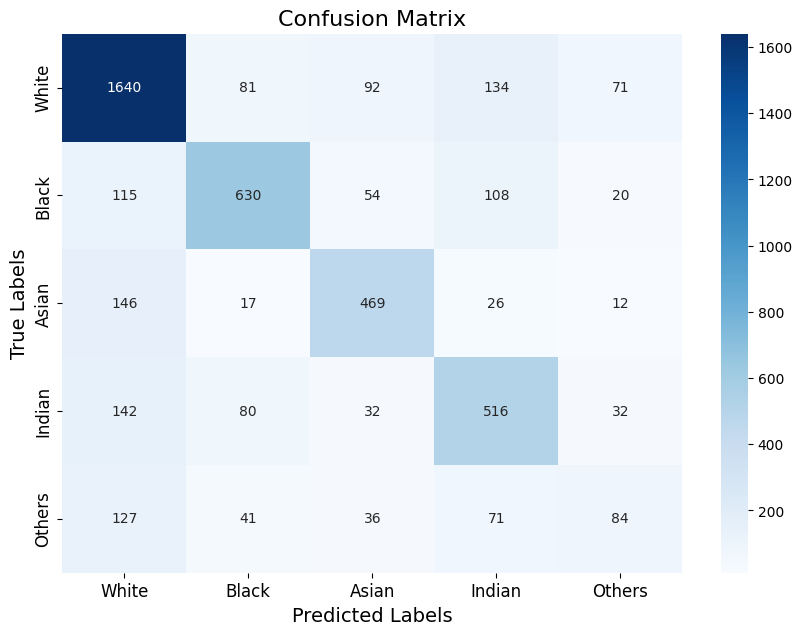


Classification Report:
              precision    recall  f1-score   support

       White       0.76      0.81      0.78      2018
       Black       0.74      0.68      0.71       927
       Asian       0.69      0.70      0.69       670
      Indian       0.60      0.64      0.62       802
      Others       0.38      0.23      0.29       359

    accuracy                           0.70      4776
   macro avg       0.63      0.61      0.62      4776
weighted avg       0.69      0.70      0.69      4776



In [8]:
all_labels = []
all_preds = []
eyes_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, e_x, e_y, drop_1, drop_2)
eyes_net.load_state_dict(torch.load("best_eyes_net.pth"))
eyes_net = eyes_net.to(device)


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = eyes_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**NOSE TRAINING VALIDATION AND TEST**

In [9]:
# Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/nose/train", transform=transform_nose)
test_dataset = EthnicityDataset(root_dir="Dataset/nose/test", transform=transform_nose)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-fold Cross-Validation
k = 5  # Choose K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array to store results for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

num_epochs = 12
batch_size = 64

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model and optimizer for each fold
    nose_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, n_x, n_y, drop_1, drop_2)
    nose_net = nose_net.to(device)  # Ensure the model is on the correct GPU/CPU
    nose_optimizer = torch.optim.Adam(nose_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Metrics for each fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training for each fold
    for epoch in range(num_epochs):
        # Training Phase
        nose_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            nose_optimizer.zero_grad()

            # Forward pass
            outputs = nose_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nose_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        nose_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = nose_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = nose_net.state_dict()
            print(f"New best model saved with Val Accuracy: {best_val_accuracy:.4f}")
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save results for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

torch.save(best_model_state, "best_nose_net.pth")

# Calculate the average metrics across all folds
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 229/229 [00:32<00:00,  7.10batch/s]


Fold 1, Epoch 1, Train Loss: 1.3087, Train Accuracy: 0.4969


Validating Fold 1, Epoch 1: 100%|██████████| 58/58 [00:05<00:00, 11.36batch/s]


New best model saved with Val Accuracy: 0.5377
Fold 1, Epoch 1, Val Loss: 1.2022, Val Accuracy: 0.5377


Training Fold 1, Epoch 2: 100%|██████████| 229/229 [00:31<00:00,  7.21batch/s]


Fold 1, Epoch 2, Train Loss: 1.1540, Train Accuracy: 0.5596


Validating Fold 1, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 12.44batch/s]


New best model saved with Val Accuracy: 0.5798
Fold 1, Epoch 2, Val Loss: 1.0886, Val Accuracy: 0.5798


Training Fold 1, Epoch 3: 100%|██████████| 229/229 [00:32<00:00,  7.15batch/s]


Fold 1, Epoch 3, Train Loss: 1.0643, Train Accuracy: 0.6024


Validating Fold 1, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.70batch/s]


New best model saved with Val Accuracy: 0.6075
Fold 1, Epoch 3, Val Loss: 1.0469, Val Accuracy: 0.6075


Training Fold 1, Epoch 4: 100%|██████████| 229/229 [00:32<00:00,  7.10batch/s]


Fold 1, Epoch 4, Train Loss: 1.0132, Train Accuracy: 0.6280


Validating Fold 1, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.97batch/s]


New best model saved with Val Accuracy: 0.6245
Fold 1, Epoch 4, Val Loss: 0.9986, Val Accuracy: 0.6245


Training Fold 1, Epoch 5: 100%|██████████| 229/229 [00:32<00:00,  7.13batch/s]


Fold 1, Epoch 5, Train Loss: 0.9562, Train Accuracy: 0.6479


Validating Fold 1, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.87batch/s]


New best model saved with Val Accuracy: 0.6406
Fold 1, Epoch 5, Val Loss: 0.9755, Val Accuracy: 0.6406


Training Fold 1, Epoch 6: 100%|██████████| 229/229 [00:32<00:00,  7.11batch/s]


Fold 1, Epoch 6, Train Loss: 0.9222, Train Accuracy: 0.6625


Validating Fold 1, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.69batch/s]


Fold 1, Epoch 6, Val Loss: 0.9713, Val Accuracy: 0.6286


Training Fold 1, Epoch 7: 100%|██████████| 229/229 [00:31<00:00,  7.23batch/s]


Fold 1, Epoch 7, Train Loss: 0.8875, Train Accuracy: 0.6764


Validating Fold 1, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 11.85batch/s]


Fold 1, Epoch 7, Val Loss: 0.9750, Val Accuracy: 0.6393


Training Fold 1, Epoch 8: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 1, Epoch 8, Train Loss: 0.8552, Train Accuracy: 0.6899


Validating Fold 1, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 11.63batch/s]


New best model saved with Val Accuracy: 0.6615
Fold 1, Epoch 8, Val Loss: 0.9247, Val Accuracy: 0.6615


Training Fold 1, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 1, Epoch 9, Train Loss: 0.8209, Train Accuracy: 0.6991


Validating Fold 1, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 12.58batch/s]


Fold 1, Epoch 9, Val Loss: 0.9558, Val Accuracy: 0.6519


Training Fold 1, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 1, Epoch 10, Train Loss: 0.7959, Train Accuracy: 0.7091


Validating Fold 1, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 12.98batch/s]


Fold 1, Epoch 10, Val Loss: 0.9390, Val Accuracy: 0.6590


Training Fold 1, Epoch 11: 100%|██████████| 229/229 [00:32<00:00,  7.09batch/s]


Fold 1, Epoch 11, Train Loss: 0.7732, Train Accuracy: 0.7162


Validating Fold 1, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 13.10batch/s]


New best model saved with Val Accuracy: 0.6689
Fold 1, Epoch 11, Val Loss: 0.9085, Val Accuracy: 0.6689


Training Fold 1, Epoch 12: 100%|██████████| 229/229 [00:32<00:00,  7.11batch/s]


Fold 1, Epoch 12, Train Loss: 0.7316, Train Accuracy: 0.7329


Validating Fold 1, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.82batch/s]


Fold 1, Epoch 12, Val Loss: 0.9924, Val Accuracy: 0.6467
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 229/229 [00:32<00:00,  7.13batch/s]


Fold 2, Epoch 1, Train Loss: 1.2993, Train Accuracy: 0.4914


Validating Fold 2, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 12.21batch/s]


Fold 2, Epoch 1, Val Loss: 1.2141, Val Accuracy: 0.5259


Training Fold 2, Epoch 2: 100%|██████████| 229/229 [00:31<00:00,  7.17batch/s]


Fold 2, Epoch 2, Train Loss: 1.1287, Train Accuracy: 0.5736


Validating Fold 2, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 11.69batch/s]


Fold 2, Epoch 2, Val Loss: 1.1177, Val Accuracy: 0.5853


Training Fold 2, Epoch 3: 100%|██████████| 229/229 [00:32<00:00,  7.14batch/s]


Fold 2, Epoch 3, Train Loss: 1.0507, Train Accuracy: 0.6057


Validating Fold 2, Epoch 3: 100%|██████████| 58/58 [00:05<00:00, 11.51batch/s]


Fold 2, Epoch 3, Val Loss: 1.0436, Val Accuracy: 0.6226


Training Fold 2, Epoch 4: 100%|██████████| 229/229 [00:32<00:00,  7.14batch/s]


Fold 2, Epoch 4, Train Loss: 0.9931, Train Accuracy: 0.6305


Validating Fold 2, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.53batch/s]


Fold 2, Epoch 4, Val Loss: 1.0087, Val Accuracy: 0.6319


Training Fold 2, Epoch 5: 100%|██████████| 229/229 [00:32<00:00,  7.11batch/s]


Fold 2, Epoch 5, Train Loss: 0.9435, Train Accuracy: 0.6478


Validating Fold 2, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.81batch/s]


Fold 2, Epoch 5, Val Loss: 1.0078, Val Accuracy: 0.6335


Training Fold 2, Epoch 6: 100%|██████████| 229/229 [00:32<00:00,  7.07batch/s]


Fold 2, Epoch 6, Train Loss: 0.9104, Train Accuracy: 0.6626


Validating Fold 2, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.94batch/s]


Fold 2, Epoch 6, Val Loss: 0.9316, Val Accuracy: 0.6647


Training Fold 2, Epoch 7: 100%|██████████| 229/229 [00:32<00:00,  7.07batch/s]


Fold 2, Epoch 7, Train Loss: 0.8806, Train Accuracy: 0.6734


Validating Fold 2, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.93batch/s]


Fold 2, Epoch 7, Val Loss: 0.9525, Val Accuracy: 0.6571


Training Fold 2, Epoch 8: 100%|██████████| 229/229 [00:32<00:00,  7.10batch/s]


Fold 2, Epoch 8, Train Loss: 0.8452, Train Accuracy: 0.6880


Validating Fold 2, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 12.77batch/s]


New best model saved with Val Accuracy: 0.6710
Fold 2, Epoch 8, Val Loss: 0.9081, Val Accuracy: 0.6710


Training Fold 2, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.28batch/s]


Fold 2, Epoch 9, Train Loss: 0.8077, Train Accuracy: 0.7035


Validating Fold 2, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 11.98batch/s]


Fold 2, Epoch 9, Val Loss: 0.9335, Val Accuracy: 0.6628


Training Fold 2, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.29batch/s]


Fold 2, Epoch 10, Train Loss: 0.7808, Train Accuracy: 0.7124


Validating Fold 2, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 11.92batch/s]


Fold 2, Epoch 10, Val Loss: 0.9846, Val Accuracy: 0.6426


Training Fold 2, Epoch 11: 100%|██████████| 229/229 [00:31<00:00,  7.24batch/s]


Fold 2, Epoch 11, Train Loss: 0.7474, Train Accuracy: 0.7264


Validating Fold 2, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 13.28batch/s]


New best model saved with Val Accuracy: 0.6771
Fold 2, Epoch 11, Val Loss: 0.9156, Val Accuracy: 0.6771


Training Fold 2, Epoch 12: 100%|██████████| 229/229 [00:32<00:00,  7.11batch/s]


Fold 2, Epoch 12, Train Loss: 0.7098, Train Accuracy: 0.7366


Validating Fold 2, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.92batch/s]


New best model saved with Val Accuracy: 0.6812
Fold 2, Epoch 12, Val Loss: 0.9082, Val Accuracy: 0.6812
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 229/229 [00:32<00:00,  7.07batch/s]


Fold 3, Epoch 1, Train Loss: 1.2980, Train Accuracy: 0.4964


Validating Fold 3, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 13.02batch/s]


Fold 3, Epoch 1, Val Loss: 1.2839, Val Accuracy: 0.4807


Training Fold 3, Epoch 2: 100%|██████████| 229/229 [00:32<00:00,  7.09batch/s]


Fold 3, Epoch 2, Train Loss: 1.1372, Train Accuracy: 0.5663


Validating Fold 3, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 12.97batch/s]


Fold 3, Epoch 2, Val Loss: 1.0743, Val Accuracy: 0.6048


Training Fold 3, Epoch 3: 100%|██████████| 229/229 [00:32<00:00,  7.12batch/s]


Fold 3, Epoch 3, Train Loss: 1.0531, Train Accuracy: 0.6056


Validating Fold 3, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.04batch/s]


Fold 3, Epoch 3, Val Loss: 1.0643, Val Accuracy: 0.6012


Training Fold 3, Epoch 4: 100%|██████████| 229/229 [00:32<00:00,  7.15batch/s]


Fold 3, Epoch 4, Train Loss: 0.9922, Train Accuracy: 0.6289


Validating Fold 3, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 11.68batch/s]


Fold 3, Epoch 4, Val Loss: 0.9933, Val Accuracy: 0.6283


Training Fold 3, Epoch 5: 100%|██████████| 229/229 [00:31<00:00,  7.19batch/s]


Fold 3, Epoch 5, Train Loss: 0.9538, Train Accuracy: 0.6481


Validating Fold 3, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 11.68batch/s]


Fold 3, Epoch 5, Val Loss: 0.9480, Val Accuracy: 0.6502


Training Fold 3, Epoch 6: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 3, Epoch 6, Train Loss: 0.9117, Train Accuracy: 0.6639


Validating Fold 3, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.66batch/s]


Fold 3, Epoch 6, Val Loss: 1.0052, Val Accuracy: 0.6239


Training Fold 3, Epoch 7: 100%|██████████| 229/229 [00:32<00:00,  7.10batch/s]


Fold 3, Epoch 7, Train Loss: 0.8775, Train Accuracy: 0.6773


Validating Fold 3, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.74batch/s]


Fold 3, Epoch 7, Val Loss: 0.9060, Val Accuracy: 0.6653


Training Fold 3, Epoch 8: 100%|██████████| 229/229 [00:32<00:00,  7.06batch/s]


Fold 3, Epoch 8, Train Loss: 0.8460, Train Accuracy: 0.6897


Validating Fold 3, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 12.63batch/s]


Fold 3, Epoch 8, Val Loss: 0.9271, Val Accuracy: 0.6532


Training Fold 3, Epoch 9: 100%|██████████| 229/229 [00:32<00:00,  7.04batch/s]


Fold 3, Epoch 9, Train Loss: 0.8170, Train Accuracy: 0.7032


Validating Fold 3, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.30batch/s]


Fold 3, Epoch 9, Val Loss: 0.9490, Val Accuracy: 0.6461


Training Fold 3, Epoch 10: 100%|██████████| 229/229 [00:32<00:00,  7.11batch/s]


Fold 3, Epoch 10, Train Loss: 0.7848, Train Accuracy: 0.7136


Validating Fold 3, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 13.07batch/s]


Fold 3, Epoch 10, Val Loss: 0.9523, Val Accuracy: 0.6571


Training Fold 3, Epoch 11: 100%|██████████| 229/229 [00:32<00:00,  7.03batch/s]


Fold 3, Epoch 11, Train Loss: 0.7564, Train Accuracy: 0.7264


Validating Fold 3, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 11.62batch/s]


Fold 3, Epoch 11, Val Loss: 0.9330, Val Accuracy: 0.6724


Training Fold 3, Epoch 12: 100%|██████████| 229/229 [00:32<00:00,  7.05batch/s]


Fold 3, Epoch 12, Train Loss: 0.7229, Train Accuracy: 0.7356


Validating Fold 3, Epoch 12: 100%|██████████| 58/58 [00:05<00:00, 11.48batch/s]


Fold 3, Epoch 12, Val Loss: 0.8924, Val Accuracy: 0.6746
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 229/229 [00:32<00:00,  7.10batch/s]


Fold 4, Epoch 1, Train Loss: 1.3165, Train Accuracy: 0.4899


Validating Fold 4, Epoch 1: 100%|██████████| 58/58 [00:05<00:00, 11.34batch/s]


Fold 4, Epoch 1, Val Loss: 1.1804, Val Accuracy: 0.5505


Training Fold 4, Epoch 2: 100%|██████████| 229/229 [00:32<00:00,  7.12batch/s]


Fold 4, Epoch 2, Train Loss: 1.1608, Train Accuracy: 0.5550


Validating Fold 4, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 11.87batch/s]


Fold 4, Epoch 2, Val Loss: 1.0534, Val Accuracy: 0.6023


Training Fold 4, Epoch 3: 100%|██████████| 229/229 [00:32<00:00,  7.08batch/s]


Fold 4, Epoch 3, Train Loss: 1.0760, Train Accuracy: 0.5950


Validating Fold 4, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.26batch/s]


Fold 4, Epoch 3, Val Loss: 0.9885, Val Accuracy: 0.6239


Training Fold 4, Epoch 4: 100%|██████████| 229/229 [00:32<00:00,  7.04batch/s]


Fold 4, Epoch 4, Train Loss: 1.0105, Train Accuracy: 0.6231


Validating Fold 4, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.66batch/s]


Fold 4, Epoch 4, Val Loss: 0.9992, Val Accuracy: 0.6272


Training Fold 4, Epoch 5: 100%|██████████| 229/229 [00:32<00:00,  7.04batch/s]


Fold 4, Epoch 5, Train Loss: 0.9691, Train Accuracy: 0.6435


Validating Fold 4, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.87batch/s]


Fold 4, Epoch 5, Val Loss: 0.9440, Val Accuracy: 0.6527


Training Fold 4, Epoch 6: 100%|██████████| 229/229 [00:32<00:00,  7.02batch/s]


Fold 4, Epoch 6, Train Loss: 0.9454, Train Accuracy: 0.6540


Validating Fold 4, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.65batch/s]


Fold 4, Epoch 6, Val Loss: 0.8964, Val Accuracy: 0.6719


Training Fold 4, Epoch 7: 100%|██████████| 229/229 [00:32<00:00,  7.03batch/s]


Fold 4, Epoch 7, Train Loss: 0.8987, Train Accuracy: 0.6696


Validating Fold 4, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.86batch/s]


Fold 4, Epoch 7, Val Loss: 0.9240, Val Accuracy: 0.6511


Training Fold 4, Epoch 8: 100%|██████████| 229/229 [00:32<00:00,  7.08batch/s]


Fold 4, Epoch 8, Train Loss: 0.8595, Train Accuracy: 0.6830


Validating Fold 4, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 11.78batch/s]


Fold 4, Epoch 8, Val Loss: 0.8767, Val Accuracy: 0.6763


Training Fold 4, Epoch 9: 100%|██████████| 229/229 [00:32<00:00,  7.12batch/s]


Fold 4, Epoch 9, Train Loss: 0.8408, Train Accuracy: 0.6901


Validating Fold 4, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 11.60batch/s]


Fold 4, Epoch 9, Val Loss: 0.8770, Val Accuracy: 0.6768


Training Fold 4, Epoch 10: 100%|██████████| 229/229 [00:32<00:00,  7.12batch/s]


Fold 4, Epoch 10, Train Loss: 0.8047, Train Accuracy: 0.7041


Validating Fold 4, Epoch 10: 100%|██████████| 58/58 [00:05<00:00, 11.47batch/s]


New best model saved with Val Accuracy: 0.6921
Fold 4, Epoch 10, Val Loss: 0.8481, Val Accuracy: 0.6921


Training Fold 4, Epoch 11: 100%|██████████| 229/229 [00:32<00:00,  7.11batch/s]


Fold 4, Epoch 11, Train Loss: 0.7814, Train Accuracy: 0.7140


Validating Fold 4, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 12.24batch/s]


Fold 4, Epoch 11, Val Loss: 0.8437, Val Accuracy: 0.6842


Training Fold 4, Epoch 12: 100%|██████████| 229/229 [00:32<00:00,  7.04batch/s]


Fold 4, Epoch 12, Train Loss: 0.7350, Train Accuracy: 0.7312


Validating Fold 4, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.80batch/s]


Fold 4, Epoch 12, Val Loss: 0.8485, Val Accuracy: 0.6861
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 229/229 [00:32<00:00,  6.95batch/s]


Fold 5, Epoch 1, Train Loss: 1.3091, Train Accuracy: 0.4889


Validating Fold 5, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 12.58batch/s]


Fold 5, Epoch 1, Val Loss: 1.1907, Val Accuracy: 0.5407


Training Fold 5, Epoch 2: 100%|██████████| 229/229 [00:32<00:00,  6.97batch/s]


Fold 5, Epoch 2, Train Loss: 1.1403, Train Accuracy: 0.5629


Validating Fold 5, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 12.48batch/s]


Fold 5, Epoch 2, Val Loss: 1.0436, Val Accuracy: 0.6045


Training Fold 5, Epoch 3: 100%|██████████| 229/229 [00:33<00:00,  6.93batch/s]


Fold 5, Epoch 3, Train Loss: 1.0494, Train Accuracy: 0.6063


Validating Fold 5, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.49batch/s]


Fold 5, Epoch 3, Val Loss: 1.0439, Val Accuracy: 0.6097


Training Fold 5, Epoch 4: 100%|██████████| 229/229 [00:32<00:00,  6.97batch/s]


Fold 5, Epoch 4, Train Loss: 1.0015, Train Accuracy: 0.6283


Validating Fold 5, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.65batch/s]


Fold 5, Epoch 4, Val Loss: 0.9575, Val Accuracy: 0.6409


Training Fold 5, Epoch 5: 100%|██████████| 229/229 [00:32<00:00,  7.01batch/s]


Fold 5, Epoch 5, Train Loss: 0.9560, Train Accuracy: 0.6456


Validating Fold 5, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.10batch/s]


Fold 5, Epoch 5, Val Loss: 0.9190, Val Accuracy: 0.6598


Training Fold 5, Epoch 6: 100%|██████████| 229/229 [00:32<00:00,  7.06batch/s]


Fold 5, Epoch 6, Train Loss: 0.9236, Train Accuracy: 0.6581


Validating Fold 5, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 11.64batch/s]


Fold 5, Epoch 6, Val Loss: 0.9340, Val Accuracy: 0.6593


Training Fold 5, Epoch 7: 100%|██████████| 229/229 [00:32<00:00,  7.06batch/s]


Fold 5, Epoch 7, Train Loss: 0.8863, Train Accuracy: 0.6722


Validating Fold 5, Epoch 7: 100%|██████████| 58/58 [00:05<00:00, 11.56batch/s]


Fold 5, Epoch 7, Val Loss: 0.9232, Val Accuracy: 0.6552


Training Fold 5, Epoch 8: 100%|██████████| 229/229 [00:32<00:00,  7.04batch/s]


Fold 5, Epoch 8, Train Loss: 0.8550, Train Accuracy: 0.6856


Validating Fold 5, Epoch 8: 100%|██████████| 58/58 [00:05<00:00, 11.30batch/s]


Fold 5, Epoch 8, Val Loss: 0.9159, Val Accuracy: 0.6637


Training Fold 5, Epoch 9: 100%|██████████| 229/229 [00:32<00:00,  7.03batch/s]


Fold 5, Epoch 9, Train Loss: 0.8209, Train Accuracy: 0.6971


Validating Fold 5, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 11.62batch/s]


Fold 5, Epoch 9, Val Loss: 0.8671, Val Accuracy: 0.6878


Training Fold 5, Epoch 10: 100%|██████████| 229/229 [00:32<00:00,  7.02batch/s]


Fold 5, Epoch 10, Train Loss: 0.7852, Train Accuracy: 0.7147


Validating Fold 5, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 11.77batch/s]


Fold 5, Epoch 10, Val Loss: 0.9157, Val Accuracy: 0.6691


Training Fold 5, Epoch 11: 100%|██████████| 229/229 [00:32<00:00,  7.03batch/s]


Fold 5, Epoch 11, Train Loss: 0.7519, Train Accuracy: 0.7270


Validating Fold 5, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 12.66batch/s]


Fold 5, Epoch 11, Val Loss: 0.9012, Val Accuracy: 0.6721


Training Fold 5, Epoch 12: 100%|██████████| 229/229 [00:33<00:00,  6.93batch/s]


Fold 5, Epoch 12, Train Loss: 0.7229, Train Accuracy: 0.7373


Validating Fold 5, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.59batch/s]

Fold 5, Epoch 12, Val Loss: 0.8695, Val Accuracy: 0.6875
Average Training Loss: 0.9355
Average Validation Loss: 0.9766
Average Training Accuracy: 0.6517
Average Validation Accuracy: 0.6384


<ipython-input-10-5fad636bf744>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nose_net.load_state_dict(torch.load("best_nose_net.pth"))


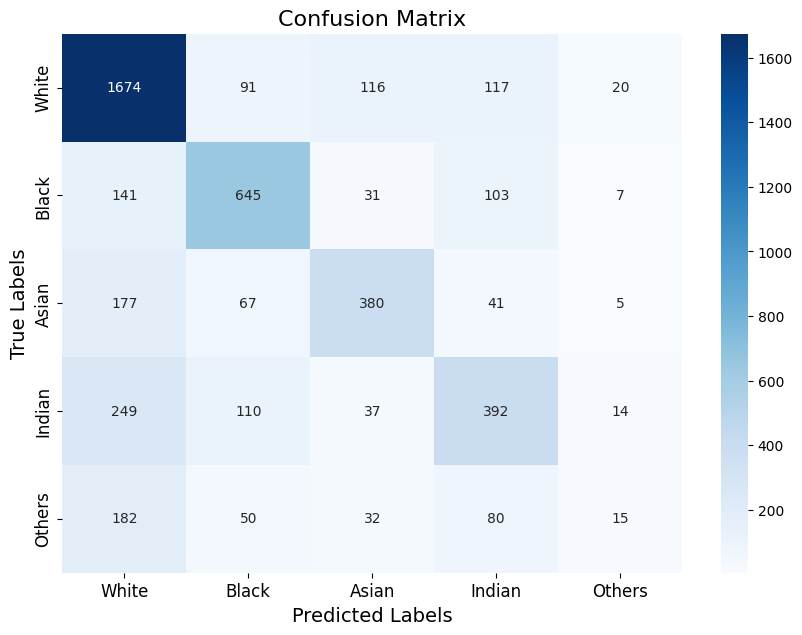


Classification Report:
              precision    recall  f1-score   support

       White       0.69      0.83      0.75      2018
       Black       0.67      0.70      0.68       927
       Asian       0.64      0.57      0.60       670
      Indian       0.53      0.49      0.51       802
      Others       0.25      0.04      0.07       359

    accuracy                           0.65      4776
   macro avg       0.56      0.52      0.52      4776
weighted avg       0.62      0.65      0.63      4776



In [10]:
all_labels = []
all_preds = []
nose_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, n_x, n_y, drop_1, drop_2)
nose_net.load_state_dict(torch.load("best_nose_net.pth"))
nose_net = nose_net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = nose_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**MOUTH TRAINING VALIDATION AND TEST**

In [7]:
# Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/mouth/train", transform=transform_mouth)
test_dataset = EthnicityDataset(root_dir="Dataset/mouth/test", transform=transform_mouth)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-fold Cross-Validation
k = 5  # Choose K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array to store results for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

num_epochs = 12
batch_size = 64

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model and optimizer for each fold
    mouth_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, m_x, m_y, drop_1, drop_2)
    mouth_net = mouth_net.to(device)  # Ensure the model is on the correct GPU/CPU
    mouth_optimizer = torch.optim.Adam(mouth_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Metrics for each fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training for each fold
    for epoch in range(num_epochs):
        # Training Phase
        mouth_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            mouth_optimizer.zero_grad()

            # Forward pass
            outputs = mouth_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            mouth_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        mouth_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = mouth_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = mouth_net.state_dict()
            print(f"New best model saved with Val Accuracy: {best_val_accuracy:.4f}")
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save results for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

torch.save(best_model_state, "best_mouth_net.pth")

# Calculate the average metrics across all folds
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 229/229 [00:40<00:00,  5.62batch/s]


Fold 1, Epoch 1, Train Loss: 1.2193, Train Accuracy: 0.5340


Validating Fold 1, Epoch 1: 100%|██████████| 58/58 [00:05<00:00, 11.50batch/s]


New best model saved with Val Accuracy: 0.5516
Fold 1, Epoch 1, Val Loss: 1.1628, Val Accuracy: 0.5516


Training Fold 1, Epoch 2: 100%|██████████| 229/229 [00:30<00:00,  7.45batch/s]


Fold 1, Epoch 2, Train Loss: 1.1203, Train Accuracy: 0.5772


Validating Fold 1, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 12.73batch/s]


New best model saved with Val Accuracy: 0.5968
Fold 1, Epoch 2, Val Loss: 1.0682, Val Accuracy: 0.5968


Training Fold 1, Epoch 3: 100%|██████████| 229/229 [00:31<00:00,  7.21batch/s]


Fold 1, Epoch 3, Train Loss: 1.0708, Train Accuracy: 0.5915


Validating Fold 1, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.86batch/s]


New best model saved with Val Accuracy: 0.5990
Fold 1, Epoch 3, Val Loss: 1.0540, Val Accuracy: 0.5990


Training Fold 1, Epoch 4: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 1, Epoch 4, Train Loss: 1.0302, Train Accuracy: 0.6105


Validating Fold 1, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 11.82batch/s]


New best model saved with Val Accuracy: 0.6190
Fold 1, Epoch 4, Val Loss: 1.0106, Val Accuracy: 0.6190


Training Fold 1, Epoch 5: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 1, Epoch 5, Train Loss: 0.9947, Train Accuracy: 0.6266


Validating Fold 1, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.19batch/s]


New best model saved with Val Accuracy: 0.6322
Fold 1, Epoch 5, Val Loss: 0.9927, Val Accuracy: 0.6322


Training Fold 1, Epoch 6: 100%|██████████| 229/229 [00:31<00:00,  7.36batch/s]


Fold 1, Epoch 6, Train Loss: 0.9644, Train Accuracy: 0.6395


Validating Fold 1, Epoch 6: 100%|██████████| 58/58 [00:05<00:00, 11.42batch/s]


New best model saved with Val Accuracy: 0.6489
Fold 1, Epoch 6, Val Loss: 0.9689, Val Accuracy: 0.6489


Training Fold 1, Epoch 7: 100%|██████████| 229/229 [00:31<00:00,  7.36batch/s]


Fold 1, Epoch 7, Train Loss: 0.9356, Train Accuracy: 0.6453


Validating Fold 1, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.71batch/s]


Fold 1, Epoch 7, Val Loss: 0.9755, Val Accuracy: 0.6343


Training Fold 1, Epoch 8: 100%|██████████| 229/229 [00:31<00:00,  7.29batch/s]


Fold 1, Epoch 8, Train Loss: 0.9047, Train Accuracy: 0.6649


Validating Fold 1, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 12.90batch/s]


Fold 1, Epoch 8, Val Loss: 0.9544, Val Accuracy: 0.6387


Training Fold 1, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.23batch/s]


Fold 1, Epoch 9, Train Loss: 0.8709, Train Accuracy: 0.6759


Validating Fold 1, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 12.84batch/s]


New best model saved with Val Accuracy: 0.6672
Fold 1, Epoch 9, Val Loss: 0.9240, Val Accuracy: 0.6672


Training Fold 1, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.29batch/s]


Fold 1, Epoch 10, Train Loss: 0.8300, Train Accuracy: 0.6938


Validating Fold 1, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 11.74batch/s]


Fold 1, Epoch 10, Val Loss: 0.9046, Val Accuracy: 0.6656


Training Fold 1, Epoch 11: 100%|██████████| 229/229 [00:31<00:00,  7.30batch/s]


Fold 1, Epoch 11, Train Loss: 0.8079, Train Accuracy: 0.7055


Validating Fold 1, Epoch 11: 100%|██████████| 58/58 [00:05<00:00, 11.17batch/s]


Fold 1, Epoch 11, Val Loss: 0.9207, Val Accuracy: 0.6631


Training Fold 1, Epoch 12: 100%|██████████| 229/229 [00:31<00:00,  7.33batch/s]


Fold 1, Epoch 12, Train Loss: 0.7741, Train Accuracy: 0.7141


Validating Fold 1, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 11.88batch/s]


Fold 1, Epoch 12, Val Loss: 0.9286, Val Accuracy: 0.6615
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 229/229 [00:31<00:00,  7.23batch/s]


Fold 2, Epoch 1, Train Loss: 1.2053, Train Accuracy: 0.5414


Validating Fold 2, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 12.85batch/s]


Fold 2, Epoch 1, Val Loss: 1.1442, Val Accuracy: 0.5711


Training Fold 2, Epoch 2: 100%|██████████| 229/229 [00:31<00:00,  7.22batch/s]


Fold 2, Epoch 2, Train Loss: 1.0985, Train Accuracy: 0.5898


Validating Fold 2, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 12.95batch/s]


Fold 2, Epoch 2, Val Loss: 1.0483, Val Accuracy: 0.6108


Training Fold 2, Epoch 3: 100%|██████████| 229/229 [00:31<00:00,  7.19batch/s]


Fold 2, Epoch 3, Train Loss: 1.0404, Train Accuracy: 0.6097


Validating Fold 2, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.75batch/s]


Fold 2, Epoch 3, Val Loss: 1.0655, Val Accuracy: 0.6004


Training Fold 2, Epoch 4: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 2, Epoch 4, Train Loss: 0.9992, Train Accuracy: 0.6259


Validating Fold 2, Epoch 4: 100%|██████████| 58/58 [00:05<00:00, 11.52batch/s]


Fold 2, Epoch 4, Val Loss: 0.9957, Val Accuracy: 0.6239


Training Fold 2, Epoch 5: 100%|██████████| 229/229 [00:31<00:00,  7.28batch/s]


Fold 2, Epoch 5, Train Loss: 0.9719, Train Accuracy: 0.6403


Validating Fold 2, Epoch 5: 100%|██████████| 58/58 [00:05<00:00, 11.29batch/s]


Fold 2, Epoch 5, Val Loss: 1.0320, Val Accuracy: 0.6228


Training Fold 2, Epoch 6: 100%|██████████| 229/229 [00:31<00:00,  7.24batch/s]


Fold 2, Epoch 6, Train Loss: 0.9314, Train Accuracy: 0.6528


Validating Fold 2, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.27batch/s]


Fold 2, Epoch 6, Val Loss: 0.9831, Val Accuracy: 0.6464


Training Fold 2, Epoch 7: 100%|██████████| 229/229 [00:31<00:00,  7.19batch/s]


Fold 2, Epoch 7, Train Loss: 0.9080, Train Accuracy: 0.6625


Validating Fold 2, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.58batch/s]


Fold 2, Epoch 7, Val Loss: 0.9491, Val Accuracy: 0.6541


Training Fold 2, Epoch 8: 100%|██████████| 229/229 [00:31<00:00,  7.18batch/s]


Fold 2, Epoch 8, Train Loss: 0.8792, Train Accuracy: 0.6774


Validating Fold 2, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 12.65batch/s]


Fold 2, Epoch 8, Val Loss: 1.0045, Val Accuracy: 0.6217


Training Fold 2, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.19batch/s]


Fold 2, Epoch 9, Train Loss: 0.8512, Train Accuracy: 0.6859


Validating Fold 2, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 12.04batch/s]


Fold 2, Epoch 9, Val Loss: 0.9369, Val Accuracy: 0.6552


Training Fold 2, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.31batch/s]


Fold 2, Epoch 10, Train Loss: 0.8152, Train Accuracy: 0.6978


Validating Fold 2, Epoch 10: 100%|██████████| 58/58 [00:05<00:00, 11.40batch/s]


Fold 2, Epoch 10, Val Loss: 0.9529, Val Accuracy: 0.6609


Training Fold 2, Epoch 11: 100%|██████████| 229/229 [00:31<00:00,  7.22batch/s]


Fold 2, Epoch 11, Train Loss: 0.7898, Train Accuracy: 0.7127


Validating Fold 2, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 11.87batch/s]


Fold 2, Epoch 11, Val Loss: 0.9394, Val Accuracy: 0.6535


Training Fold 2, Epoch 12: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 2, Epoch 12, Train Loss: 0.7576, Train Accuracy: 0.7211


Validating Fold 2, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.92batch/s]


Fold 2, Epoch 12, Val Loss: 0.9508, Val Accuracy: 0.6568
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 229/229 [00:31<00:00,  7.29batch/s]


Fold 3, Epoch 1, Train Loss: 1.2150, Train Accuracy: 0.5379


Validating Fold 3, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 12.68batch/s]


Fold 3, Epoch 1, Val Loss: 1.1063, Val Accuracy: 0.5831


Training Fold 3, Epoch 2: 100%|██████████| 229/229 [00:31<00:00,  7.25batch/s]


Fold 3, Epoch 2, Train Loss: 1.1129, Train Accuracy: 0.5749


Validating Fold 3, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 12.54batch/s]


Fold 3, Epoch 2, Val Loss: 1.0868, Val Accuracy: 0.5987


Training Fold 3, Epoch 3: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 3, Epoch 3, Train Loss: 1.0610, Train Accuracy: 0.5982


Validating Fold 3, Epoch 3: 100%|██████████| 58/58 [00:05<00:00, 10.26batch/s]


Fold 3, Epoch 3, Val Loss: 1.0163, Val Accuracy: 0.6250


Training Fold 3, Epoch 4: 100%|██████████| 229/229 [00:31<00:00,  7.22batch/s]


Fold 3, Epoch 4, Train Loss: 1.0195, Train Accuracy: 0.6156


Validating Fold 3, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 11.65batch/s]


Fold 3, Epoch 4, Val Loss: 0.9933, Val Accuracy: 0.6300


Training Fold 3, Epoch 5: 100%|██████████| 229/229 [00:31<00:00,  7.36batch/s]


Fold 3, Epoch 5, Train Loss: 0.9750, Train Accuracy: 0.6349


Validating Fold 3, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.75batch/s]


Fold 3, Epoch 5, Val Loss: 0.9905, Val Accuracy: 0.6248


Training Fold 3, Epoch 6: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 3, Epoch 6, Train Loss: 0.9428, Train Accuracy: 0.6503


Validating Fold 3, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.73batch/s]


Fold 3, Epoch 6, Val Loss: 0.9503, Val Accuracy: 0.6590


Training Fold 3, Epoch 7: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 3, Epoch 7, Train Loss: 0.9223, Train Accuracy: 0.6562


Validating Fold 3, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.96batch/s]


Fold 3, Epoch 7, Val Loss: 0.9545, Val Accuracy: 0.6472


Training Fold 3, Epoch 8: 100%|██████████| 229/229 [00:31<00:00,  7.31batch/s]


Fold 3, Epoch 8, Train Loss: 0.8776, Train Accuracy: 0.6737


Validating Fold 3, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 11.79batch/s]


Fold 3, Epoch 8, Val Loss: 0.9424, Val Accuracy: 0.6587


Training Fold 3, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 3, Epoch 9, Train Loss: 0.8567, Train Accuracy: 0.6815


Validating Fold 3, Epoch 9: 100%|██████████| 58/58 [00:05<00:00, 11.26batch/s]


Fold 3, Epoch 9, Val Loss: 0.9401, Val Accuracy: 0.6590


Training Fold 3, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 3, Epoch 10, Train Loss: 0.8274, Train Accuracy: 0.6925


Validating Fold 3, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 12.25batch/s]


Fold 3, Epoch 10, Val Loss: 0.9639, Val Accuracy: 0.6513


Training Fold 3, Epoch 11: 100%|██████████| 229/229 [00:31<00:00,  7.18batch/s]


Fold 3, Epoch 11, Train Loss: 0.7976, Train Accuracy: 0.7050


Validating Fold 3, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 12.46batch/s]


Fold 3, Epoch 11, Val Loss: 0.9393, Val Accuracy: 0.6453


Training Fold 3, Epoch 12: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 3, Epoch 12, Train Loss: 0.7681, Train Accuracy: 0.7175


Validating Fold 3, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.50batch/s]


New best model saved with Val Accuracy: 0.6806
Fold 3, Epoch 12, Val Loss: 0.9018, Val Accuracy: 0.6806
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 229/229 [00:31<00:00,  7.32batch/s]


Fold 4, Epoch 1, Train Loss: 1.2235, Train Accuracy: 0.5351


Validating Fold 4, Epoch 1: 100%|██████████| 58/58 [00:05<00:00, 11.59batch/s]


Fold 4, Epoch 1, Val Loss: 1.1056, Val Accuracy: 0.5785


Training Fold 4, Epoch 2: 100%|██████████| 229/229 [00:31<00:00,  7.28batch/s]


Fold 4, Epoch 2, Train Loss: 1.1071, Train Accuracy: 0.5764


Validating Fold 4, Epoch 2: 100%|██████████| 58/58 [00:05<00:00, 11.39batch/s]


Fold 4, Epoch 2, Val Loss: 1.1070, Val Accuracy: 0.5889


Training Fold 4, Epoch 3: 100%|██████████| 229/229 [00:31<00:00,  7.34batch/s]


Fold 4, Epoch 3, Train Loss: 1.0574, Train Accuracy: 0.5989


Validating Fold 4, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.42batch/s]


Fold 4, Epoch 3, Val Loss: 1.0231, Val Accuracy: 0.6190


Training Fold 4, Epoch 4: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 4, Epoch 4, Train Loss: 1.0174, Train Accuracy: 0.6162


Validating Fold 4, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.79batch/s]


Fold 4, Epoch 4, Val Loss: 1.0120, Val Accuracy: 0.6234


Training Fold 4, Epoch 5: 100%|██████████| 229/229 [00:31<00:00,  7.16batch/s]


Fold 4, Epoch 5, Train Loss: 0.9797, Train Accuracy: 0.6321


Validating Fold 4, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.61batch/s]


Fold 4, Epoch 5, Val Loss: 0.9895, Val Accuracy: 0.6415


Training Fold 4, Epoch 6: 100%|██████████| 229/229 [00:31<00:00,  7.24batch/s]


Fold 4, Epoch 6, Train Loss: 0.9493, Train Accuracy: 0.6465


Validating Fold 4, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.35batch/s]


Fold 4, Epoch 6, Val Loss: 0.9570, Val Accuracy: 0.6491


Training Fold 4, Epoch 7: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 4, Epoch 7, Train Loss: 0.9190, Train Accuracy: 0.6561


Validating Fold 4, Epoch 7: 100%|██████████| 58/58 [00:05<00:00, 11.15batch/s]


Fold 4, Epoch 7, Val Loss: 0.9576, Val Accuracy: 0.6549


Training Fold 4, Epoch 8: 100%|██████████| 229/229 [00:31<00:00,  7.29batch/s]


Fold 4, Epoch 8, Train Loss: 0.8842, Train Accuracy: 0.6689


Validating Fold 4, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 11.85batch/s]


Fold 4, Epoch 8, Val Loss: 0.9592, Val Accuracy: 0.6491


Training Fold 4, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 4, Epoch 9, Train Loss: 0.8624, Train Accuracy: 0.6790


Validating Fold 4, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 12.77batch/s]


Fold 4, Epoch 9, Val Loss: 0.9454, Val Accuracy: 0.6516


Training Fold 4, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.22batch/s]


Fold 4, Epoch 10, Train Loss: 0.8284, Train Accuracy: 0.6912


Validating Fold 4, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 12.83batch/s]


Fold 4, Epoch 10, Val Loss: 0.9232, Val Accuracy: 0.6678


Training Fold 4, Epoch 11: 100%|██████████| 229/229 [00:31<00:00,  7.18batch/s]


Fold 4, Epoch 11, Train Loss: 0.8013, Train Accuracy: 0.7021


Validating Fold 4, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 12.61batch/s]


Fold 4, Epoch 11, Val Loss: 0.9398, Val Accuracy: 0.6647


Training Fold 4, Epoch 12: 100%|██████████| 229/229 [00:31<00:00,  7.27batch/s]


Fold 4, Epoch 12, Train Loss: 0.7668, Train Accuracy: 0.7127


Validating Fold 4, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 11.67batch/s]


Fold 4, Epoch 12, Val Loss: 0.9204, Val Accuracy: 0.6686
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 229/229 [00:31<00:00,  7.33batch/s]


Fold 5, Epoch 1, Train Loss: 1.2257, Train Accuracy: 0.5317


Validating Fold 5, Epoch 1: 100%|██████████| 58/58 [00:05<00:00, 11.50batch/s]


Fold 5, Epoch 1, Val Loss: 1.1416, Val Accuracy: 0.5667


Training Fold 5, Epoch 2: 100%|██████████| 229/229 [00:31<00:00,  7.36batch/s]


Fold 5, Epoch 2, Train Loss: 1.1144, Train Accuracy: 0.5766


Validating Fold 5, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 13.05batch/s]


Fold 5, Epoch 2, Val Loss: 1.0955, Val Accuracy: 0.5733


Training Fold 5, Epoch 3: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 5, Epoch 3, Train Loss: 1.0637, Train Accuracy: 0.5981


Validating Fold 5, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.91batch/s]


Fold 5, Epoch 3, Val Loss: 1.0594, Val Accuracy: 0.5949


Training Fold 5, Epoch 4: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 5, Epoch 4, Train Loss: 1.0204, Train Accuracy: 0.6193


Validating Fold 5, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 13.03batch/s]


Fold 5, Epoch 4, Val Loss: 1.0467, Val Accuracy: 0.6007


Training Fold 5, Epoch 5: 100%|██████████| 229/229 [00:31<00:00,  7.29batch/s]


Fold 5, Epoch 5, Train Loss: 0.9870, Train Accuracy: 0.6335


Validating Fold 5, Epoch 5: 100%|██████████| 58/58 [00:05<00:00, 11.37batch/s]


Fold 5, Epoch 5, Val Loss: 1.0174, Val Accuracy: 0.6133


Training Fold 5, Epoch 6: 100%|██████████| 229/229 [00:31<00:00,  7.34batch/s]


Fold 5, Epoch 6, Train Loss: 0.9555, Train Accuracy: 0.6455


Validating Fold 5, Epoch 6: 100%|██████████| 58/58 [00:05<00:00, 11.44batch/s]


Fold 5, Epoch 6, Val Loss: 0.9826, Val Accuracy: 0.6280


Training Fold 5, Epoch 7: 100%|██████████| 229/229 [00:31<00:00,  7.32batch/s]


Fold 5, Epoch 7, Train Loss: 0.9268, Train Accuracy: 0.6594


Validating Fold 5, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.74batch/s]


Fold 5, Epoch 7, Val Loss: 0.9876, Val Accuracy: 0.6163


Training Fold 5, Epoch 8: 100%|██████████| 229/229 [00:31<00:00,  7.26batch/s]


Fold 5, Epoch 8, Train Loss: 0.8867, Train Accuracy: 0.6679


Validating Fold 5, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 12.90batch/s]


Fold 5, Epoch 8, Val Loss: 0.9659, Val Accuracy: 0.6311


Training Fold 5, Epoch 9: 100%|██████████| 229/229 [00:31<00:00,  7.24batch/s]


Fold 5, Epoch 9, Train Loss: 0.8655, Train Accuracy: 0.6818


Validating Fold 5, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.17batch/s]


Fold 5, Epoch 9, Val Loss: 0.9467, Val Accuracy: 0.6541


Training Fold 5, Epoch 10: 100%|██████████| 229/229 [00:31<00:00,  7.35batch/s]


Fold 5, Epoch 10, Train Loss: 0.8480, Train Accuracy: 0.6845


Validating Fold 5, Epoch 10: 100%|██████████| 58/58 [00:05<00:00, 11.51batch/s]


Fold 5, Epoch 10, Val Loss: 0.9583, Val Accuracy: 0.6464


Training Fold 5, Epoch 11: 100%|██████████| 229/229 [00:31<00:00,  7.33batch/s]


Fold 5, Epoch 11, Train Loss: 0.8036, Train Accuracy: 0.7028


Validating Fold 5, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 11.90batch/s]


Fold 5, Epoch 11, Val Loss: 0.9267, Val Accuracy: 0.6639


Training Fold 5, Epoch 12: 100%|██████████| 229/229 [00:31<00:00,  7.28batch/s]


Fold 5, Epoch 12, Train Loss: 0.7871, Train Accuracy: 0.7058


Validating Fold 5, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 12.93batch/s]

Fold 5, Epoch 12, Val Loss: 0.9533, Val Accuracy: 0.6601
Average Training Loss: 0.9505
Average Validation Loss: 0.9929
Average Training Accuracy: 0.6443
Average Validation Accuracy: 0.6321


<ipython-input-8-553f32c91c90>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mouth_net.load_state_dict(torch.load("best_mouth_net.pth"))


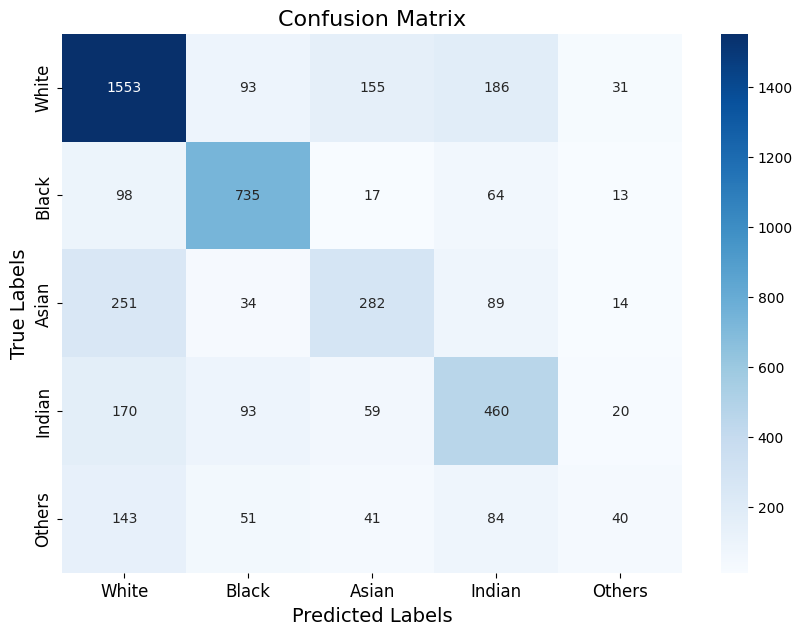


Classification Report:
              precision    recall  f1-score   support

       White       0.70      0.77      0.73      2018
       Black       0.73      0.79      0.76       927
       Asian       0.51      0.42      0.46       670
      Indian       0.52      0.57      0.55       802
      Others       0.34      0.11      0.17       359

    accuracy                           0.64      4776
   macro avg       0.56      0.53      0.53      4776
weighted avg       0.62      0.64      0.63      4776



In [8]:
all_labels = []
all_preds = []
mouth_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, m_x, m_y, drop_1, drop_2)
mouth_net.load_state_dict(torch.load("best_mouth_net.pth"))
mouth_net = mouth_net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = mouth_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))